In [33]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt

Governing Equations:

$m\ddot{x} + kx + d\dot{x} = 0$

or in state-space form:

$\dot{\mathbf{x}} = \begin{bmatrix}
0 & 1\\
-\frac{k}{m} & -\frac{d}{m}
\end{bmatrix}\mathbf{x}
$

where we set $m = 1$; $\mathbf{x} = \begin{bmatrix}x\\v\end{bmatrix}$.

In [34]:
#

k = 2        # stiffness
d = .1        # damping

# spring-mass-damper system
A = np.array([[0, 1], [-k, -d]])  # \dot{x} = Ax

In [35]:

dt = 0.01 # time step
T = 10     # amount of time to integrate
n = int(T/dt)
ts = np.linspace(0, T, n)
x0 = [2, 0]  # initial condition (x=2, v=0)
print(n)

1000


In [36]:
# compute better integral using built-in python code
# 4th-order Runge Kutta
from scipy.integrate import solve_ivp

def linear_ode(t, x):
    return A @ x

linear_ode_solution = solve_ivp(linear_ode, (0, T), x0, t_eval=ts)
xGood = linear_ode_solution.y

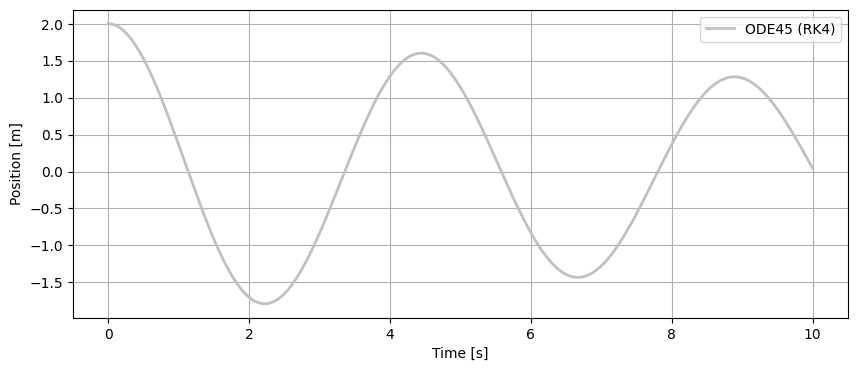

In [37]:
# Time series
plt.figure(figsize=(10, 4))
plt.plot(ts, xGood[0, :],color = "silver", lw = 2)

plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['ODE45 (RK4)'])
plt.grid(True)


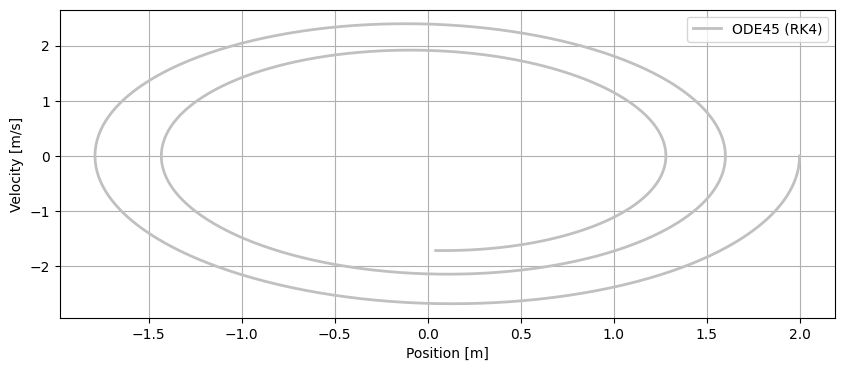

In [38]:
# Phase Plot
plt.figure(figsize=(10, 4))
plt.plot(xGood[0, :], xGood[1, :], color = "silver", lw = 2)
plt.xlabel('Position [m]')
plt.ylabel('Velocity [m/s]')
plt.legend(['ODE45 (RK4)'])
plt.grid(True)

In [39]:
n_train = int(0.1*n)
n_train = 2
u_train = xGood[0,:n_train]
t_train = ts[:n_train]
print(u_train)
print(t_train)
print(u_train.shape)
print(t_train.shape)

[2.         1.99979967]
[0.         0.01001001]
(2,)
(2,)


In [40]:
# # Sampling domain data
# domain_x = scio.loadmat(dataFile)['domain_x']
# domain_t = scio.loadmat(dataFile)['domain_t']
# domain_h = scio.loadmat(dataFile)['domain_u']

In [41]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)  # input x and t
print(reg_in)
reg_in = reg_in[:,None]
print(reg_in)
reg_label = torch.from_numpy(u_train).type(torch.float32) # output h
reg_label = reg_label[:,None]
print(reg_in.shape)
print(reg_label.shape)

f_x = np.random.uniform(0, 1, n_f)
f_t = np.random.uniform(0, 10, n_f)
f_data = np.vstack([f_x, f_t]).T

f_x = Variable(torch.from_numpy(f_data[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_t = Variable(torch.from_numpy(f_data[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset = torch.utils.data.TensorDataset(f_x, f_t)
f_data_loader = torch.utils.data.DataLoader(f_dataset, batch_size = f_batch_size, shuffle=True)

# f_t = np.random.uniform(0, 7, n_f)
# f_data = np.vstack([f_x, f_t]).T

# f_x = Variable(torch.from_numpy(f_data[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
# f_t = Variable(torch.from_numpy(f_data[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

# f_dataset = torch.utils.data.TensorDataset(f_x, f_t)
# f_data_loader = torch.utils.data.DataLoader(f_dataset, batch_size=f_batch_size, shuffle=True)

tensor([0.0000, 0.0100])
tensor([[0.0000],
        [0.0100]])
torch.Size([2, 1])
torch.Size([2, 1])


In [42]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model = MLP()

def f(t):
    u = model(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    return u_tt  + 2*u + 0.1* u_t

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [43]:
# Training the PINN
n_epoch = 20
for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader):

        optimizer.zero_grad()
        pred = model(reg_in)
        reg_loss = torch.mean((reg_label - pred) ** 2)
        f_loss = torch.mean(f(t) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

100%|██████████| 313/313 [00:01<00:00, 249.15it/s]


epoch = 0, loss = 0.43066489696502686
epoch = 0, f_loss = 0.4023427963256836
epoch = 0, reg_loss = 0.028322087600827217


100%|██████████| 313/313 [00:01<00:00, 269.52it/s]


epoch = 1, loss = 0.1546638309955597
epoch = 1, f_loss = 0.12538248300552368
epoch = 1, reg_loss = 0.02928135171532631


100%|██████████| 313/313 [00:01<00:00, 274.60it/s]


epoch = 2, loss = 0.2719346582889557
epoch = 2, f_loss = 0.2665017247200012
epoch = 2, reg_loss = 0.0054329438135027885


100%|██████████| 313/313 [00:01<00:00, 277.74it/s]


epoch = 3, loss = 0.17787981033325195
epoch = 3, f_loss = 0.17773951590061188
epoch = 3, reg_loss = 0.00014029143494553864


100%|██████████| 313/313 [00:01<00:00, 268.69it/s]


epoch = 4, loss = 0.15534380078315735
epoch = 4, f_loss = 0.1540900319814682
epoch = 4, reg_loss = 0.0012537643779069185


100%|██████████| 313/313 [00:01<00:00, 266.52it/s]


epoch = 5, loss = 0.10987392067909241
epoch = 5, f_loss = 0.10986483097076416
epoch = 5, reg_loss = 9.087947546504438e-06


100%|██████████| 313/313 [00:01<00:00, 272.02it/s]


epoch = 6, loss = 0.1698150485754013
epoch = 6, f_loss = 0.15800832211971283
epoch = 6, reg_loss = 0.011806730180978775


100%|██████████| 313/313 [00:01<00:00, 258.04it/s]


epoch = 7, loss = 0.24477902054786682
epoch = 7, f_loss = 0.2427496314048767
epoch = 7, reg_loss = 0.002029384020715952


100%|██████████| 313/313 [00:01<00:00, 260.82it/s]


epoch = 8, loss = 0.11192698031663895
epoch = 8, f_loss = 0.10305292904376984
epoch = 8, reg_loss = 0.00887405127286911


100%|██████████| 313/313 [00:01<00:00, 272.37it/s]


epoch = 9, loss = 0.08700898289680481
epoch = 9, f_loss = 0.08274325728416443
epoch = 9, reg_loss = 0.004265723749995232


100%|██████████| 313/313 [00:01<00:00, 276.08it/s]


epoch = 10, loss = 0.09420373290777206
epoch = 10, f_loss = 0.07820522040128708
epoch = 10, reg_loss = 0.015998512506484985


100%|██████████| 313/313 [00:01<00:00, 274.53it/s]


epoch = 11, loss = 0.11139301210641861
epoch = 11, f_loss = 0.10926917940378189
epoch = 11, reg_loss = 0.0021238308399915695


100%|██████████| 313/313 [00:01<00:00, 305.29it/s]


epoch = 12, loss = 0.060237277299165726
epoch = 12, f_loss = 0.06023701652884483
epoch = 12, reg_loss = 2.612176217553497e-07


100%|██████████| 313/313 [00:01<00:00, 312.70it/s]


epoch = 13, loss = 0.017170291393995285
epoch = 13, f_loss = 0.01659979298710823
epoch = 13, reg_loss = 0.0005704981158487499


100%|██████████| 313/313 [00:01<00:00, 309.86it/s]


epoch = 14, loss = 0.001332186977379024
epoch = 14, f_loss = 0.0012590246042236686
epoch = 14, reg_loss = 7.3162344051525e-05


100%|██████████| 313/313 [00:00<00:00, 318.40it/s]


epoch = 15, loss = 0.0014749837573617697
epoch = 15, f_loss = 0.0009320419048890471
epoch = 15, reg_loss = 0.0005429418524727225


100%|██████████| 313/313 [00:01<00:00, 312.22it/s]


epoch = 16, loss = 0.0007503392407670617
epoch = 16, f_loss = 0.000570957432501018
epoch = 16, reg_loss = 0.0001793818228179589


100%|██████████| 313/313 [00:00<00:00, 316.55it/s]


epoch = 17, loss = 0.008214364759624004
epoch = 17, f_loss = 0.007612679619342089
epoch = 17, reg_loss = 0.0006016855477355421


100%|██████████| 313/313 [00:00<00:00, 316.57it/s]


epoch = 18, loss = 0.008900287561118603
epoch = 18, f_loss = 0.008123346604406834
epoch = 18, reg_loss = 0.0007769409567117691


100%|██████████| 313/313 [00:01<00:00, 311.59it/s]

epoch = 19, loss = 0.007523254957050085
epoch = 19, f_loss = 0.007361846510320902
epoch = 19, reg_loss = 0.00016140847583301365


In [44]:
# Train a pure MLP
model_mlp = MLP()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp.zero_grad()
        pred = model_mlp(reg_in)
        mlp_loss = torch.mean((reg_label - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))


epoch = 0, loss = 3.9174344539642334
epoch = 1, loss = 2.754492998123169
epoch = 2, loss = 1.8110463619232178
epoch = 3, loss = 1.0628716945648193
epoch = 4, loss = 0.5037088394165039
epoch = 5, loss = 0.1467762291431427
epoch = 6, loss = 0.003862965852022171
epoch = 7, loss = 0.05266287922859192
epoch = 8, loss = 0.20927132666110992
epoch = 9, loss = 0.35458022356033325
epoch = 10, loss = 0.41272830963134766
epoch = 11, loss = 0.37590593099594116
epoch = 12, loss = 0.27590373158454895
epoch = 13, loss = 0.15643863379955292
epoch = 14, loss = 0.05733683705329895
epoch = 15, loss = 0.0052808551117777824
epoch = 16, loss = 0.007797996513545513
epoch = 17, loss = 0.051250800490379333
epoch = 18, loss = 0.1066206693649292
epoch = 19, loss = 0.14440366625785828
epoch = 20, loss = 0.14920422434806824
epoch = 21, loss = 0.1233534887433052
epoch = 22, loss = 0.08088362962007523
epoch = 23, loss = 0.0387667641043663
epoch = 24, loss = 0.00998503714799881
epoch = 25, loss = 1.566296850796789e-05

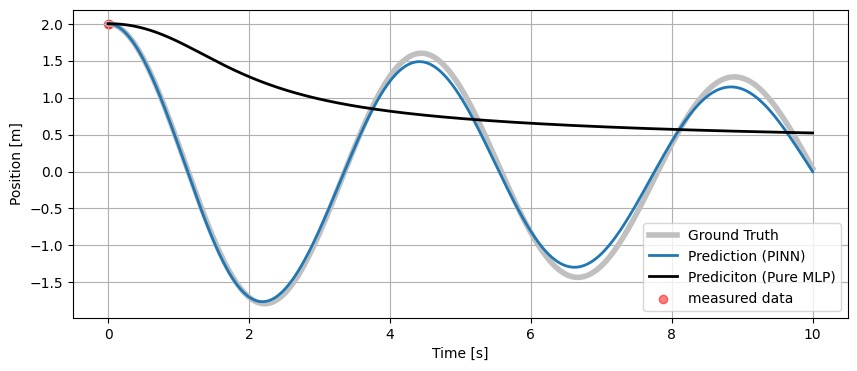

In [45]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, xGood[0, :],color = "silver", lw = 4)
plt.plot(ts, model( ts_torch ).detach().numpy(),lw = 2)
plt.plot(ts, model_mlp( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, u_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)